In [1]:
# Подгрузим необходимые для работы библиотеки
import glob
import numpy as np 
import pandas as pd 
import scipy
import copy
from scipy import signal, fftpack
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
import seaborn as sns
%matplotlib inline
with pd.option_context("display.max_rows", 10, "display.max_columns", 20):
    print(pd.get_option("display.max_rows")) 
    print(pd.get_option("display.max_columns"))
FN = 3

Using TensorFlow backend.
/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/py_36_env/lib/python3.6/site-packages/tenso

10
20


# Преобразование переменных 

Применим все необходимые преобразования а также создадим набор данных используя файлы признаков и целевой переменной 

In [15]:
class SOP:
    control_results = None
    smoothed_control_results = None
    hord_shift = 145
    pc_shift = 50 
    pc_schemes = [3,4,5,6,9,10]
    hord_schemes = [1,2,7,8,11,12,13,14,15,16]
    transverse_defects_columns = [7,8,15,16]
    longitudinal_defects_set = None # Список тактов отслеживающих продольные дефекты
    transverse_defects_set = None # Список тактов отслеживающих поперечные дефекты
    
    def __init__(self, filepath="SOP1.txt"):
        self.filepath = filepath
        
    def read_control_results(self):
        # В рамках текущего модуля пока избавимся от первого столбца с номерами измерений, пока в них нет необходимости
        splited_info = ""
        with open(self.filepath, mode="r", encoding="cp1251") as f:
            splited_info = f.readline()
        self.control_results=pd.read_csv(self.filepath, encoding="cp1251", delimiter = " ", header = None, skiprows = 1)
        self.control_results = self.control_results.drop(columns=[0])
        splited_info = splited_info.split(' ')
        self.date = splited_info[1]
        self.time = splited_info[2]
        self.temperature = splited_info[3]
        self.name = splited_info[16] 
        
    def fix_shift_issue(self):
        self.control_results = self.control_results.iloc[:1024]
        self.smoothed_control_results = self.smoothed_control_results.iloc[:1024]
        for scheme in self.pc_schemes:
            self.control_results[scheme] = np.roll(self.control_results[scheme], -self.pc_shift)
            self.smoothed_control_results[scheme] = np.roll(self.smoothed_control_results[scheme], -self.pc_shift)
        
        for scheme in self.hord_schemes:
            self.control_results[scheme] = np.roll(self.control_results[scheme], -self.hord_shift)
            self.smoothed_control_results[scheme] = np.roll(self.smoothed_control_results[scheme], -self.hord_shift)
    
    def smooth_control_results(self):
        self.smoothed_control_results = copy.deepcopy(self.control_results)
        for cont_res in self.control_results:
            self.smoothed_control_results[cont_res] = savgol_filter(self.control_results[cont_res], 15, 3)
    
    def split_by_defects(self):
        self.longitudinal_defects_set = self.smoothed_control_results.drop(self.transverse_defects_columns, axis=1)
        self.transverse_defects_set = self.smoothed_control_results[self.transverse_defects_columns]
        
    def load_target_variable(self, filepath):
        self.control_results["y"] = 0
        self.smoothed_control_results["y"] = 0
        target = pd.read_csv(filepath)
        self.longitudinal_defects_set['y'] = 0
        self.transverse_defects_set['y'] = 0
        

In [16]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()
timeseries.info()

ModuleNotFoundError: No module named 'tsfresh'

In [17]:
sop_list = []
sop_files = glob.glob("*.dat")
for file_path in sop_files:
    sop_list.append(SOP(file_path))

for sop in sop_list:
    sop.read_control_results()
    sop.smooth_control_results()
    sop.fix_shift_issue()
    sop.split_by_defects()

sop_list[0].load_target_variable("target/target1.csv")
sop_list[0].longitudinal_defects_set['y'][60]
sop_list[1].load_target_variable("target/target2.csv")
sop_list[1].longitudinal_defects_set['y'][60]
sop_list[1].load_target_variable("target/target3.csv")
sop_list[1].longitudinal_defects_set['y'][60]

/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0

In [18]:
target = pd.read_csv('target/target1.csv')
target.head(10)

,Начало дефекта,Длина дефекта,Высота дефекта,Тип дефекта,Сторона
0,51,42.0,7,L,A
1,200,40.0,6,L,B
2,278,39.0,4,L,A
3,365,43.0,6,L,B
4,460,27.0,5,L,A
5,845,36.0,4,L,B
6,959,62.0,6,L,A
7,141,NaN,4,T,


In [19]:
def display_values(dataframe, smooth_dataframe):
    assert isinstance(dataframe, pd.DataFrame)
    for column in dataframe.columns:
        plt.figure(figsize=(15,3))
        plt.title(column)
        plt.plot(dataframe[column])
        plt.plot(smooth_dataframe[column], color='red')
        plt.show()
        
def display_distribution(dataframe):
    assert isinstance(dataframe, pd.DataFrame)
    for column in dataframe.columns:
        plt.figure(figsize=(8,8))
        plt.title(column)
        dataframe[column].plot(kind="density")
        plt.show()

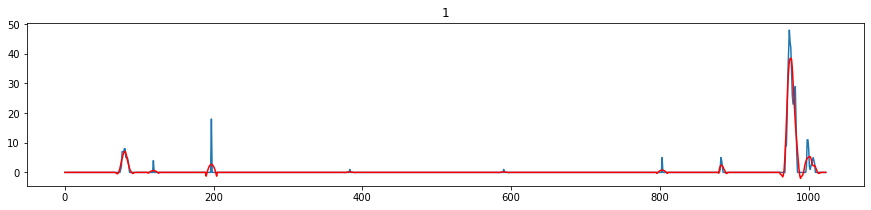

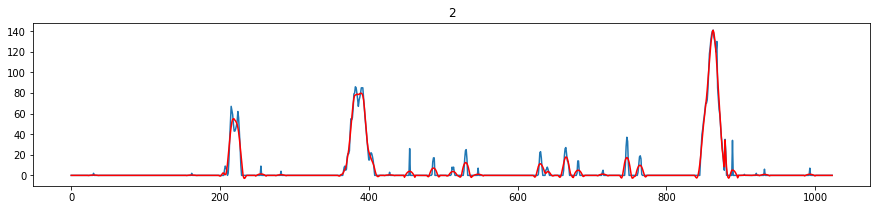

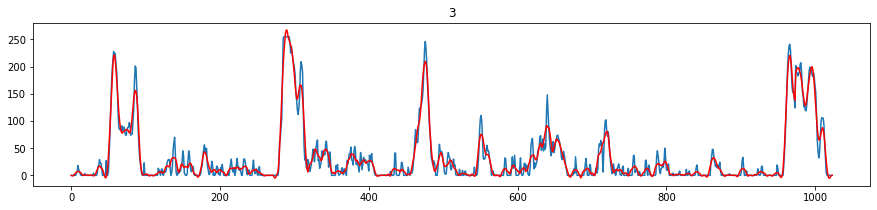

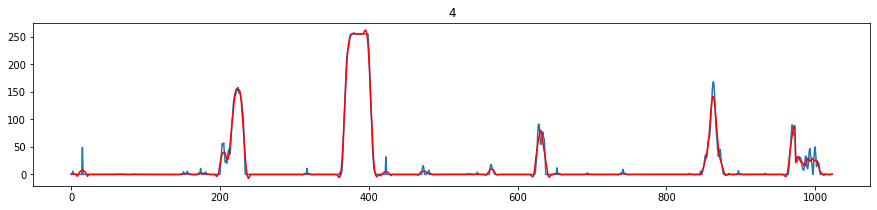

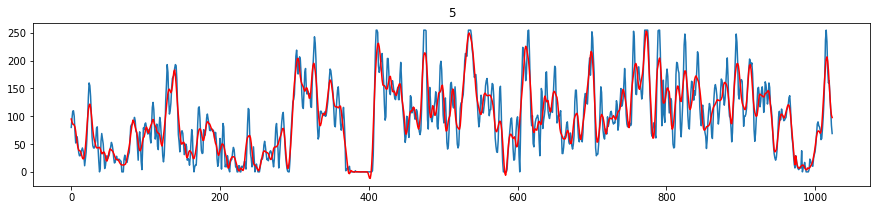

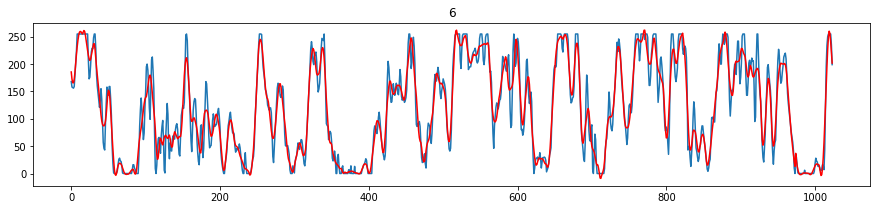

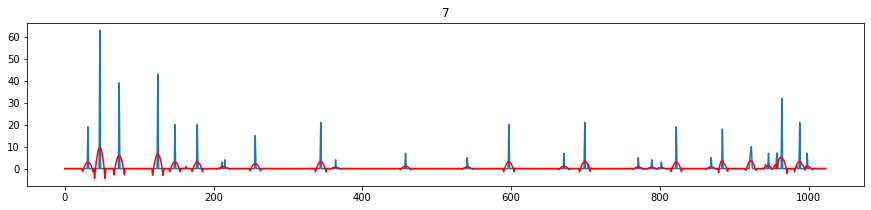

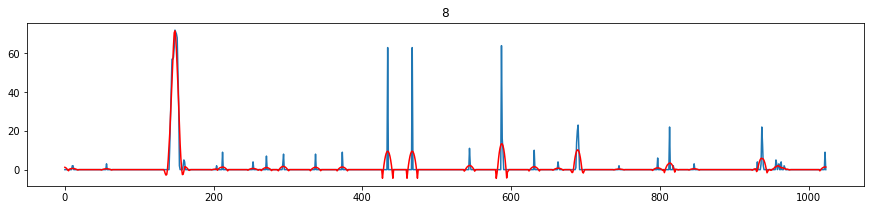

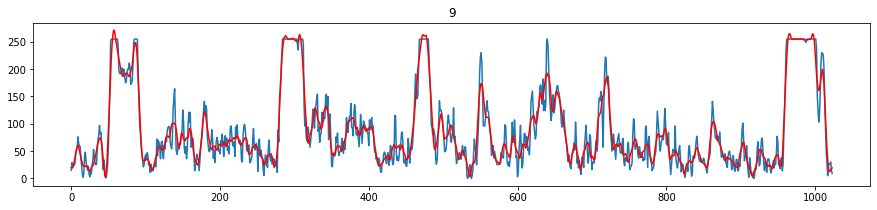

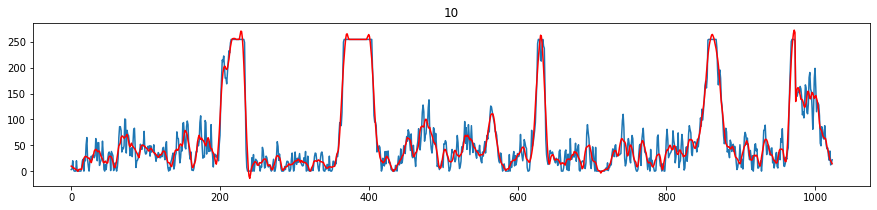

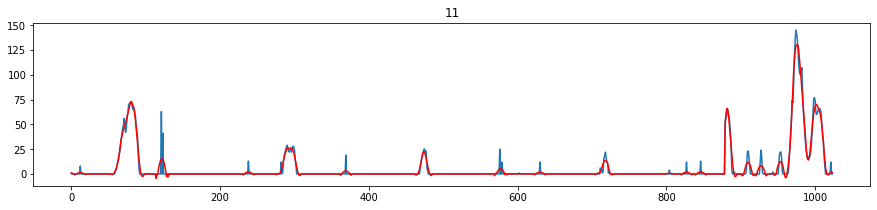

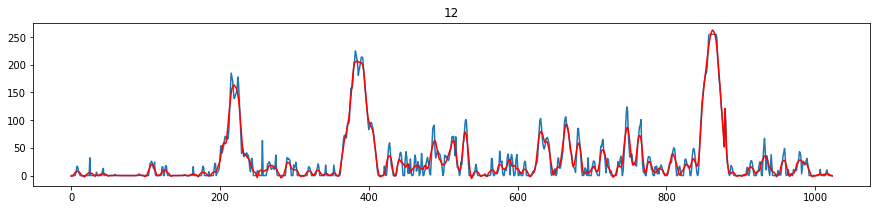

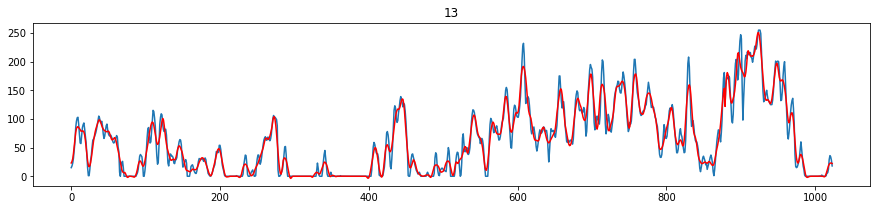

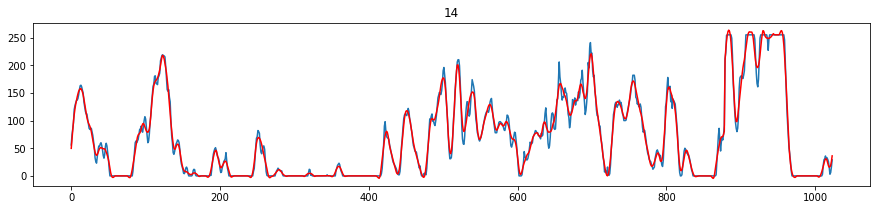

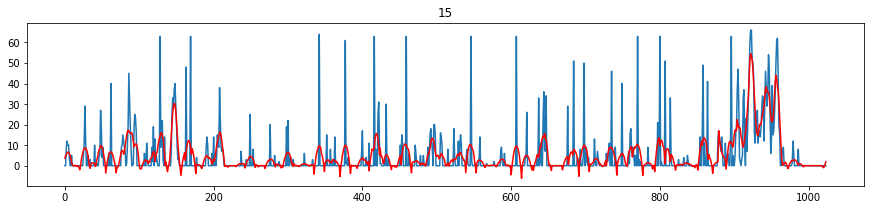

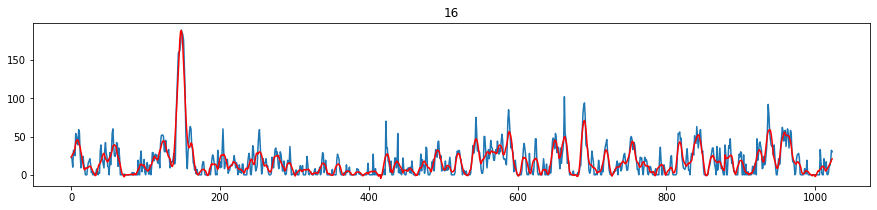

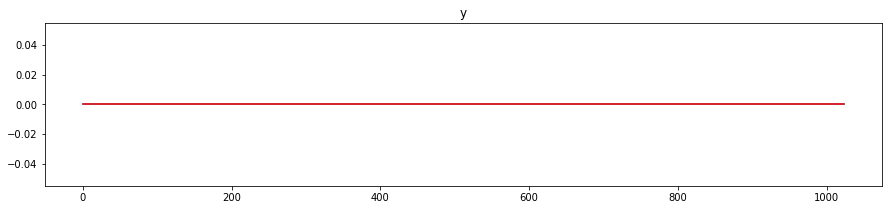

In [20]:
display_values(sop_list[FN].control_results,sop_list[FN].smoothed_control_results)

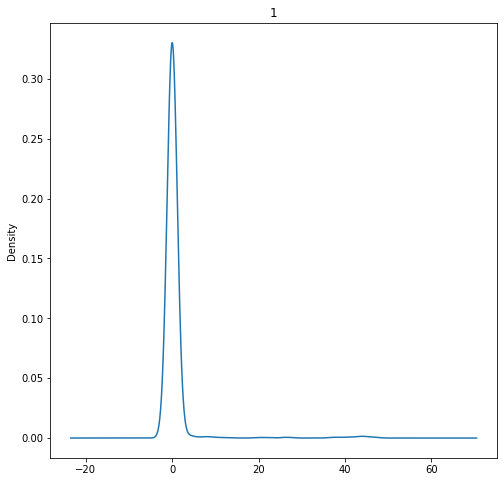

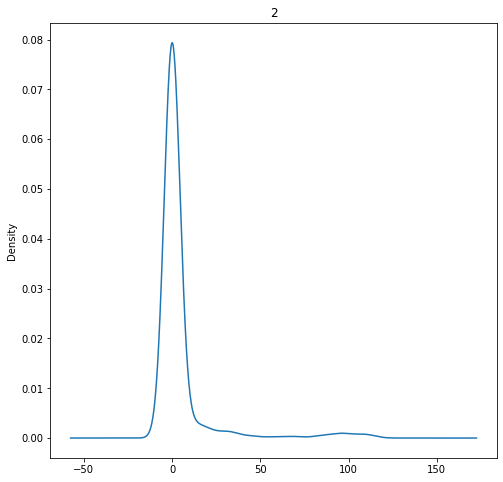

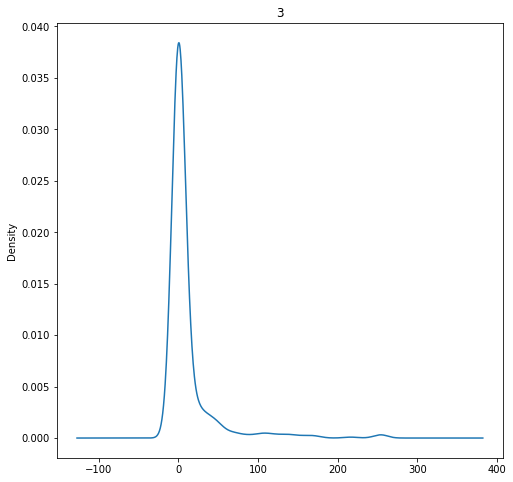

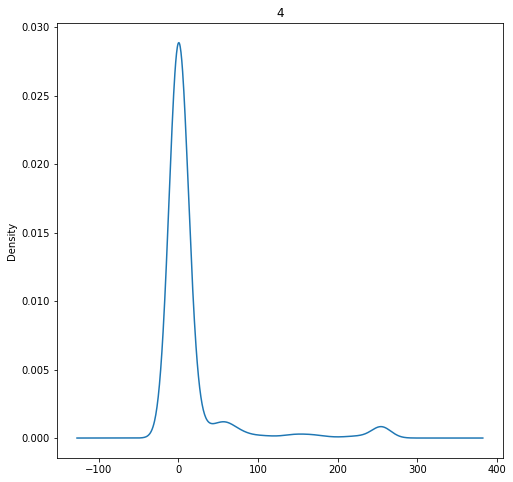

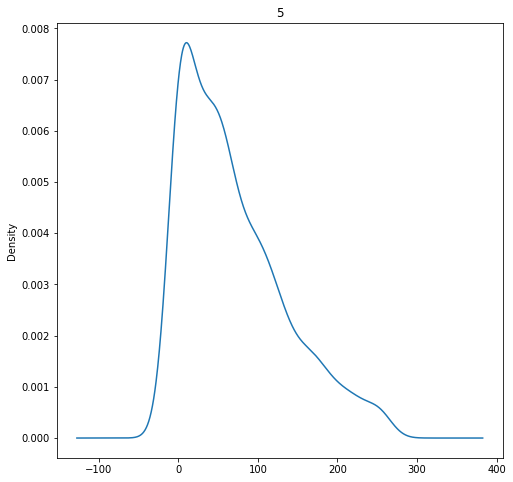

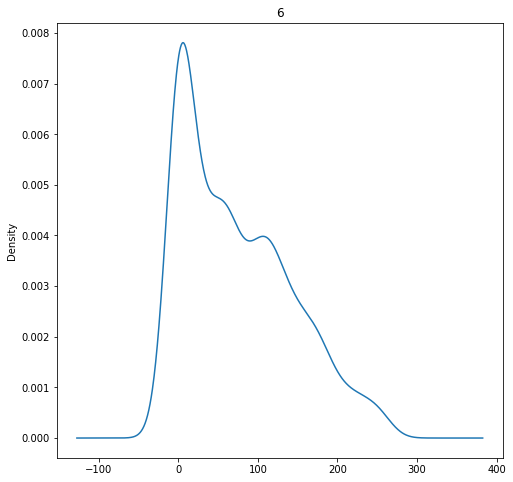

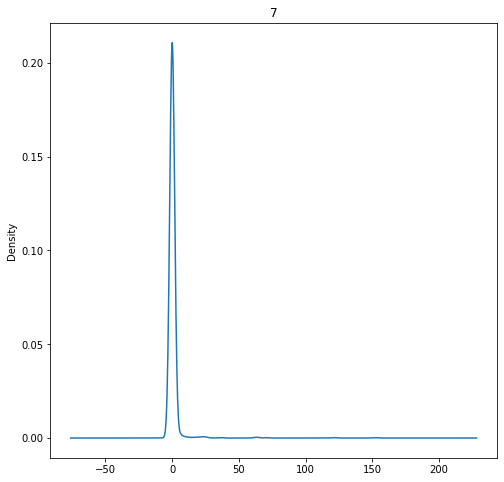

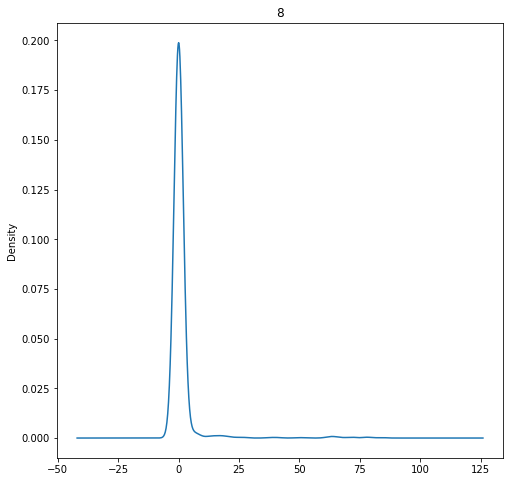

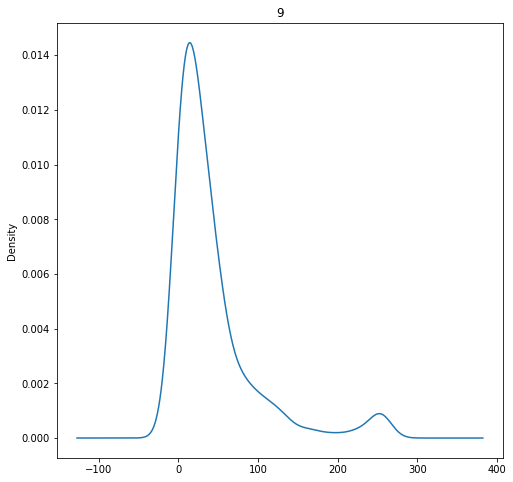

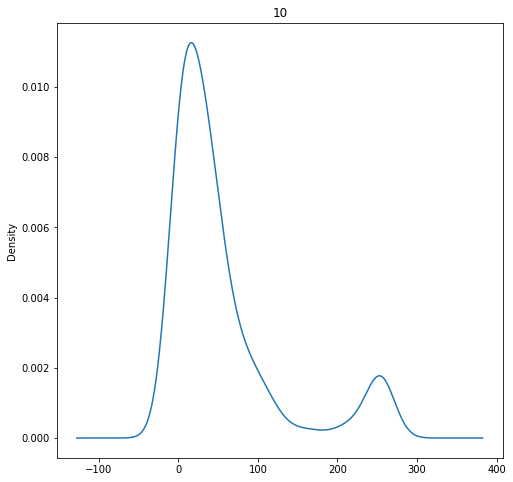

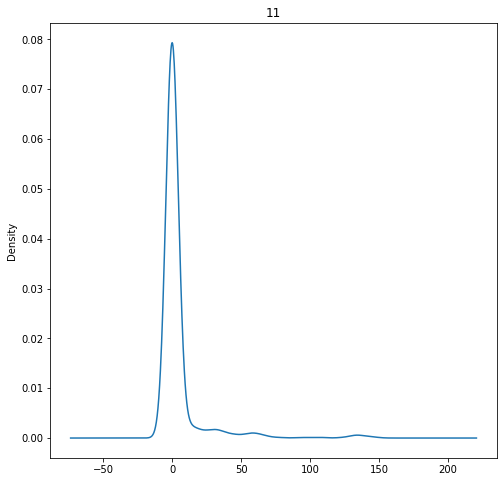

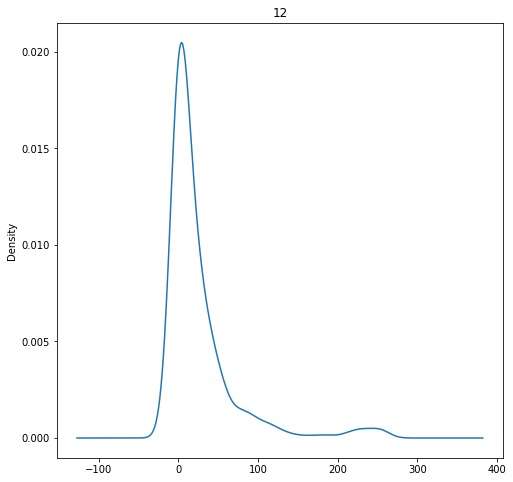

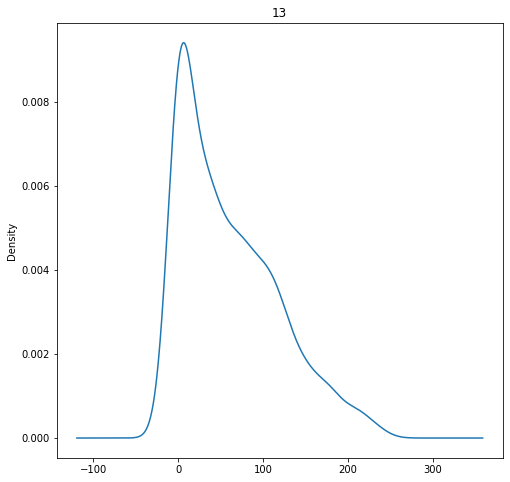

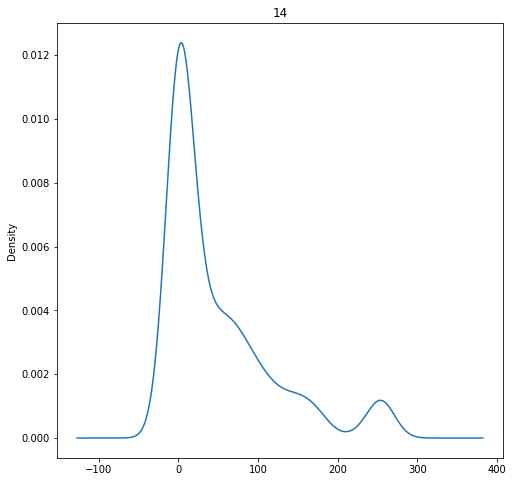

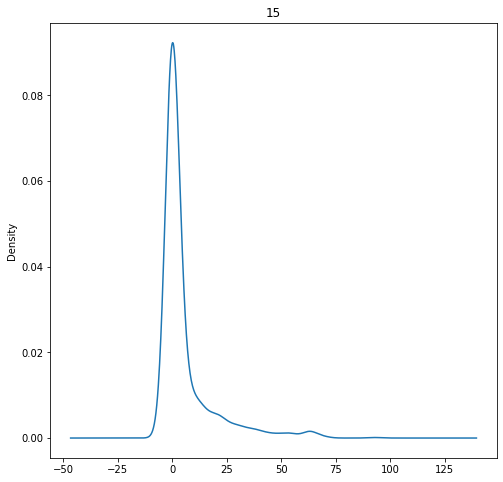

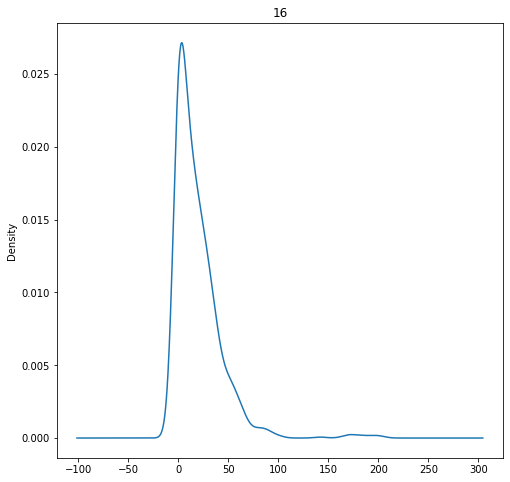

In [119]:
display_distribution(sop_list[FN].control_results)

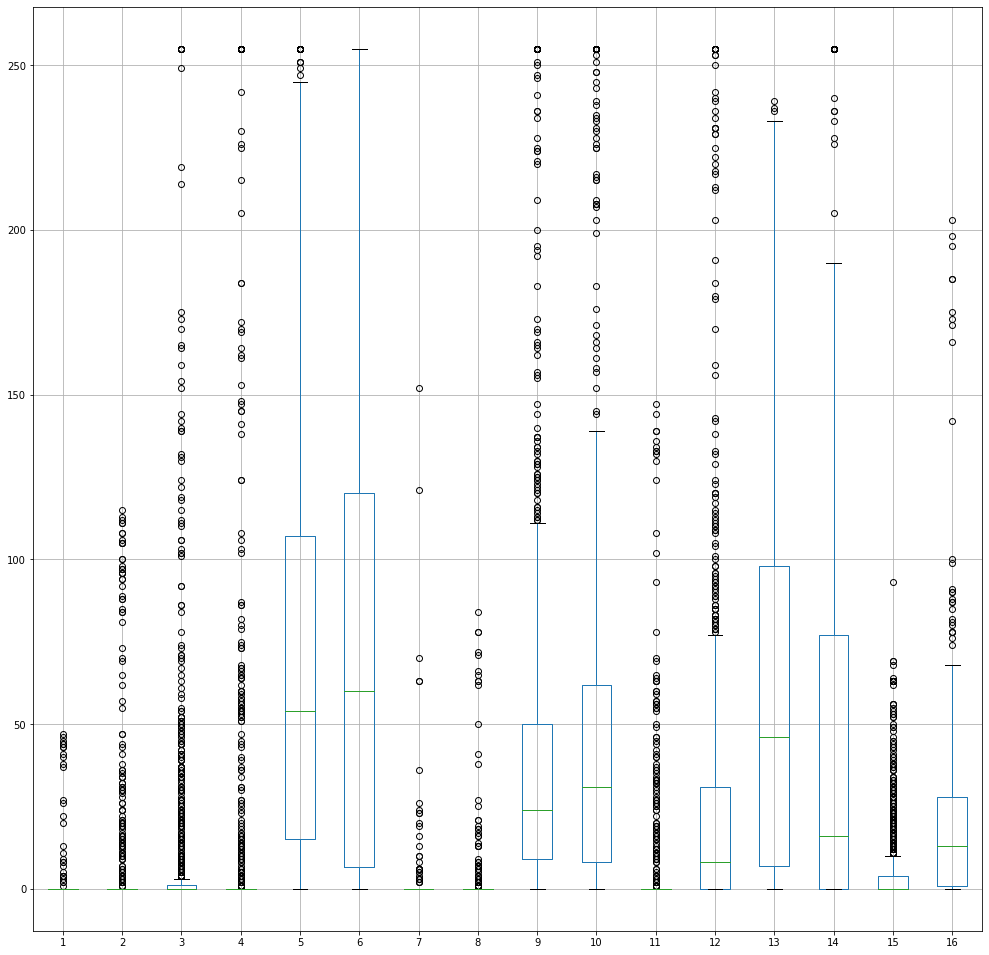

In [120]:
boxplot = sop_list[FN].control_results.boxplot(figsize=(17,17))

# ВЫБОР ПЕРЕМЕННЫХ ИЗ ИСХОДНОГО НАБОРА ДАННЫХ

In [21]:
class SOP:
    control_results = None
    smoothed_control_results = None
    hord_shift = 145
    pc_shift = 50 
    pc_schemes = [3,4,5,6,9,10]
    hord_schemes = [1,2,7,8,11,12,13,14,15,16]
    transverse_defects_columns = [7,8,15,16]
    longitudinal_defects_set = None # Список тактов отслеживающих продольные дефекты
    transverse_defects_set = None # Список тактов отслеживающих поперечные дефекты
    
    def __init__(self, filepath="SOP1.txt"):
        self.filepath = filepath
        
    def read_control_results(self):
        # В рамках текущего модуля пока избавимся от первого столбца с номерами измерений, пока в них нет необходимости
        splited_info = ""
        with open(self.filepath, mode="r", encoding="cp1251") as f:
            splited_info = f.readline()
        self.control_results=pd.read_csv(self.filepath, encoding="cp1251", delimiter = " ", header = None, skiprows = 1)
        self.control_results = self.control_results.drop(columns=[0])
        self.control_results.dropna()
        splited_info = splited_info.split(' ')
        self.date = splited_info[1]
        self.time = splited_info[2]
        self.temperature = splited_info[3]
        self.name = splited_info[16] 
        
    def fix_shift_issue(self):
        self.control_results = self.control_results.iloc[:1024]
        self.smoothed_control_results = self.smoothed_control_results.iloc[:1024]
        for scheme in self.pc_schemes:
            self.control_results[scheme] = np.roll(self.control_results[scheme], -self.pc_shift)
            self.smoothed_control_results[scheme] = np.roll(self.smoothed_control_results[scheme], -self.pc_shift)
        
        for scheme in self.hord_schemes:
            self.control_results[scheme] = np.roll(self.control_results[scheme], -self.hord_shift)
            self.smoothed_control_results[scheme] = np.roll(self.smoothed_control_results[scheme], -self.hord_shift)
    
    def smooth_control_results(self):
        self.smoothed_control_results = copy.deepcopy(self.control_results)
        for cont_res in self.control_results:
            self.smoothed_control_results[cont_res] = savgol_filter(self.control_results[cont_res], 15, 3)
    
    def split_by_defects(self):
        self.longitudinal_defects_set = self.smoothed_control_results.drop(self.transverse_defects_columns, axis=1)
        self.transverse_defects_set = self.smoothed_control_results[self.transverse_defects_columns]
        
    def load_target_variable(self, filepath):
        target = pd.read_csv(filepath)
        self.longitudinal_defects_set['y'] = 0
        self.transverse_defects_set['y'] = 0
        # Fill l defect
        for index, row in target[target['Тип дефекта'] == "L"].iterrows():
            self.longitudinal_defects_set["y"][int(row["Начало дефекта"]):int(row["Начало дефекта"]) + int(row["Длина дефекта"])] = 1

        for index, row in target[target['Тип дефекта'] == "T"].iterrows():
            self.transverse_defects_set["y"][int(row["Начало дефекта"]):15 + int(row["Начало дефекта"])] = 1
             

In [22]:
sop_list = []
sop_files = glob.glob("*.dat")
for file_path in sop_files:
    print(file_path)
    sop_list.append(SOP(file_path))

for sop in sop_list:
    sop.read_control_results()
    sop.smooth_control_results()
    sop.fix_shift_issue()
    sop.split_by_defects()
    
len(sop_list)

SOP3.dat
SOP1.dat
SOP2.dat


3

In [23]:
sop_list[0].load_target_variable("target/target1.csv")
sop_list[0].longitudinal_defects_set['y'][60]

/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jurgen/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jurgen/py_36_env

1

Построим матрицу корреляции для исходного набора данных <br/>
Используя матрицу корреляции мы можем исключить незначащие данные по коэффициенту корреляции, и тем самым облегчить возможность корректной настройки модели классификации <br/>
Можно отбросить признаки за номерами: 11, 4, 3, 16, 7

Основной целью построения корреляционной матрицы является подтверждение гипотезы о отсутствии взаимосвязей между тактами выявляющих поперечные несплошности и тактами выявляющими продольные несплошности. После этого мы можем Перейти к раздельному отбору переменных для продольный и поперечной несплошности для построению двух моделей классификации по каждой из вышеуказанных несплошностей. 
И также поставить задачу и интерпретацию результата. 

In [5]:
corr = sop_list[0].longitudinal_defects_set.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,1,2,3,4,5,6,9,10,11,12,13,14,y
1,1,-0.048,0.35,0.058,-0.18,-0.2,0.34,0.21,0.8,-0.047,-0.066,-0.13,0.23
2,-0.048,1,-0.083,0.69,-0.18,-0.17,-0.051,0.67,-0.09,0.94,-0.2,-0.2,0.41
3,0.35,-0.083,1,0.018,-0.16,-0.4,0.95,0.11,0.55,-0.12,-0.29,-0.34,0.59
4,0.058,0.69,0.018,1,-0.39,-0.36,0.074,0.82,0.0099,0.73,-0.28,-0.27,0.47
5,-0.18,-0.18,-0.16,-0.39,1,0.34,-0.18,-0.34,-0.22,-0.19,0.29,0.25,-0.33
6,-0.2,-0.17,-0.4,-0.36,0.34,1,-0.45,-0.43,-0.32,-0.19,0.41,0.43,-0.51
9,0.34,-0.051,0.95,0.074,-0.18,-0.45,1,0.17,0.55,-0.081,-0.36,-0.38,0.61
10,0.21,0.67,0.11,0.82,-0.34,-0.43,0.17,1,0.2,0.72,-0.31,-0.31,0.59
11,0.8,-0.09,0.55,0.0099,-0.22,-0.32,0.55,0.2,1,-0.12,-0.12,-0.15,0.42
12,-0.047,0.94,-0.12,0.73,-0.19,-0.19,-0.081,0.72,-0.12,1,-0.17,-0.17,0.41


На основании матрицы исключим из набора данных признак под номером 12, 10, 11

In [6]:
corr1 = sop_list[0].transverse_defects_set.corr()
corr1.style.background_gradient(cmap='coolwarm').set_precision(2)

,7,8,15,16,y
7,1,0.095,0.2,0.15,0.08
8,0.095,1,0.22,0.77,0.88
15,0.2,0.22,1,0.28,0.17
16,0.15,0.77,0.28,1,0.69
y,0.08,0.88,0.17,0.69,1


На основании матрицы исключим из набора данных признак под номером 16 

# ВЫБОР И ПОСТРОЕНИЕ НОВЫХ ПЕРЕМЕННЫХ; ТЕСТИРОВАНИЕ ЗНАЧИМОСТИ ВЫБРАННЫХ ПЕРЕМЕННЫХ

In [7]:
data = sop_list[0].longitudinal_defects_set
from tsfresh import extract_features
data['id'] = 0
y = data["y"]
data = data.drop(columns=["y"],axis=1)
data.info()

from tsfresh import extract_relevant_features
X = extract_relevant_features(data, y, column_id='id')

print(X.info())
print(X.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 13 columns):
1     1024 non-null float64
2     1024 non-null float64
3     1024 non-null float64
4     1024 non-null float64
5     1024 non-null float64
6     1024 non-null float64
9     1024 non-null float64
10    1024 non-null float64
11    1024 non-null float64
12    1024 non-null float64
13    1024 non-null float64
14    1024 non-null float64
id    1024 non-null int64
dtypes: float64(12), int64(1)
memory usage: 104.1 KB


ValueError: The following ids are in y but are missing inside the time series container: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023}

In [18]:
help(extract_features)

NameError: name 'extract_features' is not defined

# АРГУМЕНТИРОВАННЫЙ ВЫБОР АЛГОРИТМА ДЛЯ КЛАСТЕРИЗАЦИИ

Далее перейдем к построению модели и вытащим значения из класса

Модель для продольных дефектов

In [26]:
from catboost import CatBoostClassifier
train_data = np.array(sop_list[0].longitudinal_defects_set.drop(columns=["y"],axis=1))
print(train_data)
train_labels = np.array(sop_list[0].transverse_defects_set['y'])
model = CatBoostClassifier(iterations=1000)
# Fit model
model.fit(train_data, train_labels)
# Get predictions
preds = model.predict(train_data)

[[ 0.          0.         -0.28235294 ... -1.09411765 23.19276018
  49.80452489]
 [ 0.          0.         -0.54117647 ... -1.21538462 25.70588235
  65.8081448 ]
 [ 0.          0.         -1.20090498 ... -0.53393665 30.56289593
  82.79728507]
 ...
 [ 0.          0.         -2.17647059 ...  0.61266968 23.07873303
  18.89954751]
 [ 0.          0.         -0.35294118 ... -0.45972851 23.08778281
  25.91040724]
 [ 0.          0.          0.         ... -0.96470588 22.23076923
  36.17013575]]
Learning rate set to 0.016867
0:	learn: 0.6582208	total: 20.8ms	remaining: 20.8s
1:	learn: 0.6258258	total: 35.3ms	remaining: 17.6s
2:	learn: 0.5924074	total: 45.4ms	remaining: 15.1s
3:	learn: 0.5638451	total: 54.9ms	remaining: 13.7s
4:	learn: 0.5368306	total: 62.9ms	remaining: 12.5s
5:	learn: 0.5097681	total: 71ms	remaining: 11.8s
6:	learn: 0.4791369	total: 79.2ms	remaining: 11.2s
7:	learn: 0.4543981	total: 87.6ms	remaining: 10.9s
8:	learn: 0.4279646	total: 98.8ms	remaining: 10.9s
9:	learn: 0.4069805	t

168:	learn: 0.0129733	total: 1.98s	remaining: 9.75s
169:	learn: 0.0128474	total: 1.99s	remaining: 9.73s
170:	learn: 0.0127987	total: 2s	remaining: 9.72s
171:	learn: 0.0127558	total: 2.02s	remaining: 9.71s
172:	learn: 0.0125531	total: 2.03s	remaining: 9.69s
173:	learn: 0.0123553	total: 2.04s	remaining: 9.66s
174:	learn: 0.0123091	total: 2.04s	remaining: 9.63s
175:	learn: 0.0122270	total: 2.05s	remaining: 9.62s
176:	learn: 0.0120567	total: 2.06s	remaining: 9.59s
177:	learn: 0.0118909	total: 2.07s	remaining: 9.57s
178:	learn: 0.0116602	total: 2.08s	remaining: 9.54s
179:	learn: 0.0114983	total: 2.09s	remaining: 9.51s
180:	learn: 0.0114838	total: 2.1s	remaining: 9.48s
181:	learn: 0.0113434	total: 2.1s	remaining: 9.46s
182:	learn: 0.0111637	total: 2.11s	remaining: 9.44s
183:	learn: 0.0110612	total: 2.12s	remaining: 9.41s
184:	learn: 0.0109066	total: 2.13s	remaining: 9.38s
185:	learn: 0.0108921	total: 2.14s	remaining: 9.36s
186:	learn: 0.0107727	total: 2.15s	remaining: 9.33s
187:	learn: 0.010

327:	learn: 0.0039345	total: 3.6s	remaining: 7.38s
328:	learn: 0.0039140	total: 3.61s	remaining: 7.37s
329:	learn: 0.0039037	total: 3.63s	remaining: 7.37s
330:	learn: 0.0038883	total: 3.64s	remaining: 7.36s
331:	learn: 0.0038664	total: 3.66s	remaining: 7.36s
332:	learn: 0.0038183	total: 3.67s	remaining: 7.34s
333:	learn: 0.0038057	total: 3.67s	remaining: 7.33s
334:	learn: 0.0037921	total: 3.68s	remaining: 7.31s
335:	learn: 0.0037686	total: 3.69s	remaining: 7.3s
336:	learn: 0.0037591	total: 3.71s	remaining: 7.29s
337:	learn: 0.0037479	total: 3.71s	remaining: 7.28s
338:	learn: 0.0037073	total: 3.73s	remaining: 7.26s
339:	learn: 0.0036882	total: 3.73s	remaining: 7.25s
340:	learn: 0.0036611	total: 3.74s	remaining: 7.23s
341:	learn: 0.0036400	total: 3.75s	remaining: 7.21s
342:	learn: 0.0036334	total: 3.76s	remaining: 7.2s
343:	learn: 0.0036242	total: 3.77s	remaining: 7.18s
344:	learn: 0.0035945	total: 3.77s	remaining: 7.17s
345:	learn: 0.0035670	total: 3.79s	remaining: 7.16s
346:	learn: 0.0

487:	learn: 0.0018873	total: 5.21s	remaining: 5.47s
488:	learn: 0.0018836	total: 5.24s	remaining: 5.48s
489:	learn: 0.0018803	total: 5.26s	remaining: 5.47s
490:	learn: 0.0018735	total: 5.28s	remaining: 5.47s
491:	learn: 0.0018587	total: 5.29s	remaining: 5.46s
492:	learn: 0.0018556	total: 5.3s	remaining: 5.46s
493:	learn: 0.0018534	total: 5.32s	remaining: 5.44s
494:	learn: 0.0018432	total: 5.33s	remaining: 5.43s
495:	learn: 0.0018331	total: 5.34s	remaining: 5.42s
496:	learn: 0.0018296	total: 5.35s	remaining: 5.42s
497:	learn: 0.0018205	total: 5.36s	remaining: 5.4s
498:	learn: 0.0018154	total: 5.37s	remaining: 5.39s
499:	learn: 0.0018055	total: 5.38s	remaining: 5.38s
500:	learn: 0.0017986	total: 5.38s	remaining: 5.36s
501:	learn: 0.0017940	total: 5.39s	remaining: 5.35s
502:	learn: 0.0017905	total: 5.4s	remaining: 5.34s
503:	learn: 0.0017770	total: 5.41s	remaining: 5.33s
504:	learn: 0.0017747	total: 5.42s	remaining: 5.32s
505:	learn: 0.0017708	total: 5.44s	remaining: 5.31s
506:	learn: 0.0

659:	learn: 0.0011041	total: 7.26s	remaining: 3.74s
660:	learn: 0.0011015	total: 7.28s	remaining: 3.73s
661:	learn: 0.0010978	total: 7.29s	remaining: 3.72s
662:	learn: 0.0010944	total: 7.31s	remaining: 3.71s
663:	learn: 0.0010912	total: 7.32s	remaining: 3.71s
664:	learn: 0.0010865	total: 7.34s	remaining: 3.7s
665:	learn: 0.0010833	total: 7.35s	remaining: 3.68s
666:	learn: 0.0010805	total: 7.36s	remaining: 3.67s
667:	learn: 0.0010786	total: 7.37s	remaining: 3.66s
668:	learn: 0.0010753	total: 7.39s	remaining: 3.65s
669:	learn: 0.0010723	total: 7.4s	remaining: 3.64s
670:	learn: 0.0010707	total: 7.41s	remaining: 3.63s
671:	learn: 0.0010672	total: 7.42s	remaining: 3.62s
672:	learn: 0.0010652	total: 7.43s	remaining: 3.61s
673:	learn: 0.0010635	total: 7.44s	remaining: 3.6s
674:	learn: 0.0010602	total: 7.45s	remaining: 3.59s
675:	learn: 0.0010565	total: 7.47s	remaining: 3.58s
676:	learn: 0.0010537	total: 7.48s	remaining: 3.57s
677:	learn: 0.0010506	total: 7.49s	remaining: 3.56s
678:	learn: 0.0

828:	learn: 0.0007677	total: 9.3s	remaining: 1.92s
829:	learn: 0.0007669	total: 9.32s	remaining: 1.91s
830:	learn: 0.0007657	total: 9.33s	remaining: 1.9s
831:	learn: 0.0007646	total: 9.35s	remaining: 1.89s
832:	learn: 0.0007636	total: 9.35s	remaining: 1.88s
833:	learn: 0.0007619	total: 9.37s	remaining: 1.86s
834:	learn: 0.0007602	total: 9.38s	remaining: 1.85s
835:	learn: 0.0007584	total: 9.39s	remaining: 1.84s
836:	learn: 0.0007566	total: 9.4s	remaining: 1.83s
837:	learn: 0.0007548	total: 9.41s	remaining: 1.82s
838:	learn: 0.0007539	total: 9.42s	remaining: 1.81s
839:	learn: 0.0007523	total: 9.43s	remaining: 1.79s
840:	learn: 0.0007509	total: 9.44s	remaining: 1.78s
841:	learn: 0.0007502	total: 9.44s	remaining: 1.77s
842:	learn: 0.0007487	total: 9.45s	remaining: 1.76s
843:	learn: 0.0007471	total: 9.46s	remaining: 1.75s
844:	learn: 0.0007462	total: 9.47s	remaining: 1.74s
845:	learn: 0.0007454	total: 9.48s	remaining: 1.73s
846:	learn: 0.0007439	total: 9.48s	remaining: 1.71s
847:	learn: 0.0

987:	learn: 0.0005961	total: 11.1s	remaining: 135ms
988:	learn: 0.0005956	total: 11.1s	remaining: 124ms
989:	learn: 0.0005948	total: 11.1s	remaining: 113ms
990:	learn: 0.0005939	total: 11.2s	remaining: 101ms
991:	learn: 0.0005928	total: 11.2s	remaining: 90.1ms
992:	learn: 0.0005923	total: 11.2s	remaining: 78.9ms
993:	learn: 0.0005915	total: 11.2s	remaining: 67.7ms
994:	learn: 0.0005903	total: 11.2s	remaining: 56.4ms
995:	learn: 0.0005895	total: 11.2s	remaining: 45.1ms
996:	learn: 0.0005888	total: 11.2s	remaining: 33.8ms
997:	learn: 0.0005879	total: 11.3s	remaining: 22.5ms
998:	learn: 0.0005872	total: 11.3s	remaining: 11.3ms
999:	learn: 0.0005867	total: 11.3s	remaining: 0us


In [8]:
# preds = model.predict(train_data)
print(train_labels[53])
print(sop_list[0].longitudinal_defects_set['y'][53])

NameError: name 'train_labels' is not defined

In [10]:
train_data = np.array(sop_list[0].longitudinal_defects_set.drop(columns=["y"],axis=1))
print(train_data)
train_labels = np.array(sop_list[0].transverse_defects_set['y'])


model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(train_data.shape(0), 4)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
model.fit(X_train, y_train, epochs=3, batch_size=64)

[[ 0.          0.         -0.28235294 ... 23.19276018 49.80452489
   0.        ]
 [ 0.          0.         -0.54117647 ... 25.70588235 65.8081448
   0.        ]
 [ 0.          0.         -1.20090498 ... 30.56289593 82.79728507
   0.        ]
 ...
 [ 0.          0.         -2.17647059 ... 23.07873303 18.89954751
   0.        ]
 [ 0.          0.         -0.35294118 ... 23.08778281 25.91040724
   0.        ]
 [ 0.          0.          0.         ... 22.23076923 36.17013575
   0.        ]]


TypeError: 'tuple' object is not callable

# РЕЗУЛЬТАТ КЛАСТЕРНОГО АНАЛИЗА

In [32]:
vector = pd.DataFrame(train_labels)
vector.to_csv("pred1.csv")

# Посмотрим что изменилось в методе главных компонент 

In [92]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(sop_list[0].smoothed_control_results.values)

sop_list[0].smoothed_control_results['pca-one'] = pca_result[:,0]
sop_list[0].smoothed_control_results['pca-two'] = pca_result[:,1] 
sop_list[0].smoothed_control_results['pca-three'] = pca_result[:,2]

print('Объясненная вариация по основному компоненту: {}'.format(pca.explained_variance_ratio_))

Объясненная вариация по основному компоненту: [0.34876929 0.20746915 0.16173565]


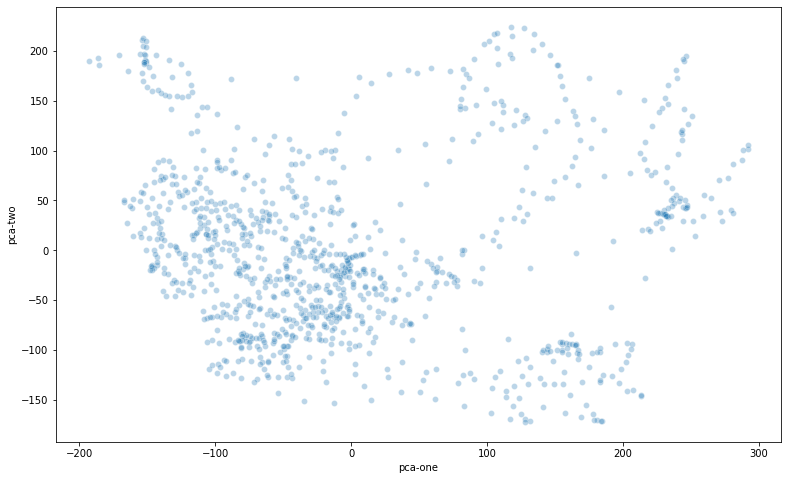

In [93]:
plt.figure(figsize=(13,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=sop_list[0].smoothed_control_results,
    legend="full",
    alpha=0.3
)

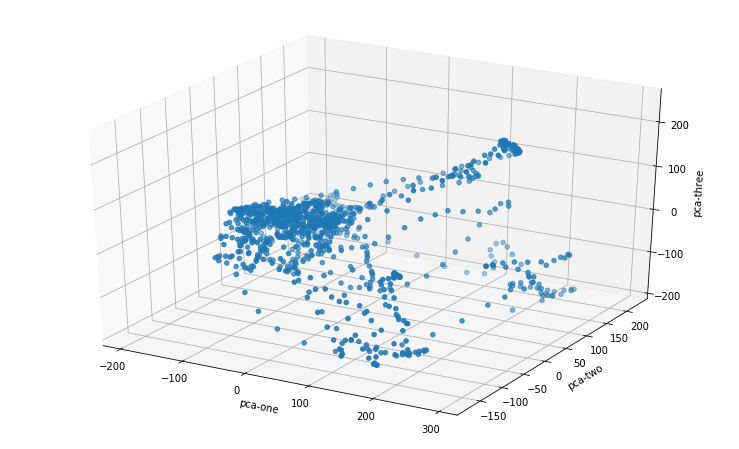

In [94]:
ax = plt.figure(figsize=(13,8)).gca(projection='3d')
ax.scatter(
    xs=sop_list[0].smoothed_control_results["pca-one"], 
    ys=sop_list[0].smoothed_control_results["pca-two"], 
    zs=sop_list[0].smoothed_control_results["pca-three"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

Пока такое представление нам мало о чём говорит, но всё же какие то выводы сделать возможно. Оба представления показывают что в наборе данных всё же есть какое то разделение на кластеры, видно плотный сгусток точек и отдаленный от него разряженную область точек. гипотетически что на 2х мерном, что на 3х мерном представлении может быть: <br/>
1) Разделение на тип несплошности   <br/>
2) Разделение на наличие несплошности  <br/>
3) Разделение на сторону  <br/>
4) Разделение на метод УЗ <br/>
Но это всего лишь гипотезы, и в данной задаче мы не ставим цели из исследовать. 

In [18]:
Cars = {'a': [1,2,3],
        'b': [1,2,3]
        }

df = pd.DataFrame(Cars)
df.head()

,a,b
0,1,1
1,2,2
2,3,3


In [19]:
df["a"] = np.roll(df["a"],-1)
df.head()

,a,b
0,2,1
1,3,2
2,1,3
